# Comparing Between Two Experiment 

## Introduction

The aim of this tutorial is to use the ExperimentSet API to compare the results between two experiment using the Experiment and ExperimentSet API. 

## Background: 


In the current experiments, we are going to compare blood samples from two donors, named LRSA and LRSB. In both cases, the blood sample have been incubated with candida albicans for 96hrs followed by classical peptide elution, see The previous tutorial for more details about the Experiment API. 

## Load the Modules 

In [1]:
from IPTK.DataStructure.Experiment import Experiment 
from IPTK.DataStructure.ExperimentalSet import ExperimentSet
from IPTK.IO.InFunctions import load_identification_table
from IPTK.IO.InFunctions import parse_text_table
from IPTK.DataStructure.Proband import Proband 
from IPTK.DataStructure.HLASet import HLASet
from IPTK.DataStructure.Database import SeqDB, GeneExpressionDB, CellularLocationDB, OrganismDB
from IPTK.DataStructure.Tissue import Tissue
from IPTK.Visualization.vizTools import plot_overlap_heatmap
from IPTK.Visualization.vizTools import plot_change_in_presentation_between_experiment
import numpy as np 
import pandas as pd 
from typing import List, Dict 

## Define the experiment-invarients 

In [2]:
seqs: SeqDB = SeqDB(path2fasta='data/uniprot_sprot.fasta')
expresson_profile: GeneExpressionDB= GeneExpressionDB(path2data='../resources/rna_tissue_consensus.tsv')
protein_locations: CellularLocationDB= CellularLocationDB(path2data='../resources/subcellular_location.tsv')
tissue: Tissue = Tissue(name='total PBMC',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)

## Define the experimental varient 

In [3]:
proband_one: Proband =Proband(name='LRS_A')
proband_two: Proband =Proband(name='LRS_B')
hla_one: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01'])
hla_two: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:02'])

## Load the input tables

In [4]:
table_one: pd.DataFrame = parse_text_table(path2file='LRS_A.csv',
                    sep=';', path2fastaDB='data/uniprot_sprot.fasta')
table_two: pd.DataFrame = parse_text_table(path2file='LRS_B.csv',
                    sep=';', path2fastaDB='data/uniprot_sprot.fasta')

## Create the experiments 


In [5]:
# define experiment one 
exp_1: Experiment = Experiment(proband=proband_one,hla_set=hla_one, 
                    tissue=tissue, database=seqs,ident_table=table_one)
# define experiment two 
exp_2: Experiment = Experiment(proband=proband_two,hla_set=hla_two, 
                    tissue=tissue, database=seqs,ident_table=table_two)

## Annotate the experimental objects with the organism information 

### Construct an organism DB 

In [6]:
org_db=OrganismDB('data/uniprot_sprot.fasta')
print(org_db)

An organism database with: 562755 entry.


### annotate the proteins with organism information

In [7]:
exp_1.annotate_proteins(org_db)
exp_2.annotate_proteins(org_db)

## Create an ExperimentalSet Object 

In [8]:
exps: ExperimentSet = ExperimentSet(LRS_A=exp_1, LRS_B=exp_2)

## The Basic Functionaility of the ExperimentSet API 

### Getting the number of alleles in the set 


In [11]:
num_alleles: Dict[str,int] = exps.get_allele_count()
for allele in num_alleles.keys():
    print(f'{allele} --> {num_alleles[allele]}')

HLA-DRB1*15:01 --> 2
HLA-DRB1*13:01 --> 1
HLA-DRB1*13:02 --> 1


### Getting the name of the probands in the samples

In [11]:
names = exps.get_experimental_names()
for name in names:
    print(f'The following is a memeber :: {name}')

The following is a memeber :: LRS_A
The following is a memeber :: LRS_B


In canse more than one sample, is drown from the same proband, we can get the number of experimental objects, i.e. samples, per proband as follow: 


In [12]:
sample_per_objects: Dict[str, int] = exps.get_proband_count()
for pro in sample_per_objects.keys():
    print(f'Proband: {pro} --> count: {sample_per_objects[pro]}')

Proband: LRS_A --> count: 1
Proband: LRS_B --> count: 1


we can also do the counting per tissue, as follow

In [13]:
samples_pro_tissue: Dict[str, int] = exps.get_tissue_counts()
for tissue in samples_pro_tissue.keys():
    print(f'Proband: {tissue} --> count: {samples_pro_tissue[tissue]}')

Proband: total PBMC --> count: 2


## The Grouping operator 

The grouping functions enable you to group experiments in the experimental set and return a NEW experimental set object containing the grouped experiments. Currently, IPTK support two types of grouping; group-by-allele and group-by-proband and group-by-tissue. 

### Grouping by proband 

In [14]:
group_proband:Dict[str,ExperimentSet] = exps.group_by_proband()
for proband in group_proband.keys():
    print(f'Proband: {proband} --> Experimental-Set: {group_proband[proband]} --> Names: {group_proband[proband].get_experimental_names()}')

Proband: LRS_A --> Experimental-Set: an experimental set with 1 Experiments in it --> Names: ['LRS_A0']
Proband: LRS_B --> Experimental-Set: an experimental set with 1 Experiments in it --> Names: ['LRS_B0']


### Grouping by tissue

In [15]:
group_tissue:Dict[str,ExperimentSet] = exps.group_by_tissue()
for tissue in group_tissue.keys():
    print(f'Allele: {tissue} --> Experimental-Set: {group_tissue[tissue]} --> Names: {group_tissue[tissue].get_experimental_names()}')

Allele: total PBMC --> Experimental-Set: an experimental set with 2 Experiments in it --> Names: ['total PBMC0', 'total PBMC1']


For more information about the Grouping check the online documentation 

## The Organism Methods

### Getting unique proteins in the set

In [16]:
orgs: List[str] = exps.get_unique_orgs()
for org in orgs: 
    print(f"Found ==> {org}")

Found ==> CANAL
Found ==> CANAX
Found ==> BOVIN
Found ==> RABIT
Found ==> HUMAN
Found ==> HORSE
Found ==> CANAW


### Getting the peptide count per organims set-wide

In [17]:
exps.get_total_peptide_per_org_count()

,Organisms,Counts
4,HUMAN,7990
2,BOVIN,2573
0,CANAL,190
1,CANAX,101
6,CANAW,49
3,RABIT,8
5,HORSE,4


### Compare the count of peptid-per-organism accross set-wide 

In [18]:
res_human: pd.DataFrame = exps.compare_org_count_among_exps(org='HUMAN')
print(res_human)

       LRS_A  LRS_B
LRS_A    0.0 -122.0
LRS_B  122.0    0.0


In [19]:
res_bovin: pd.DataFrame = exps.compare_org_count_among_exps(org='BOVIN')
res_bovin

,LRS_A,LRS_B
LRS_A,0.0,-73.0
LRS_B,73.0,0.0


In [20]:
res_candida: pd.DataFrame= exps.compare_org_count_among_exps(org='CANAL')
res_candida    

,LRS_A,LRS_B
LRS_A,0.0,22.0
LRS_B,-22.0,0.0


### Visualize the difference in peptide count 

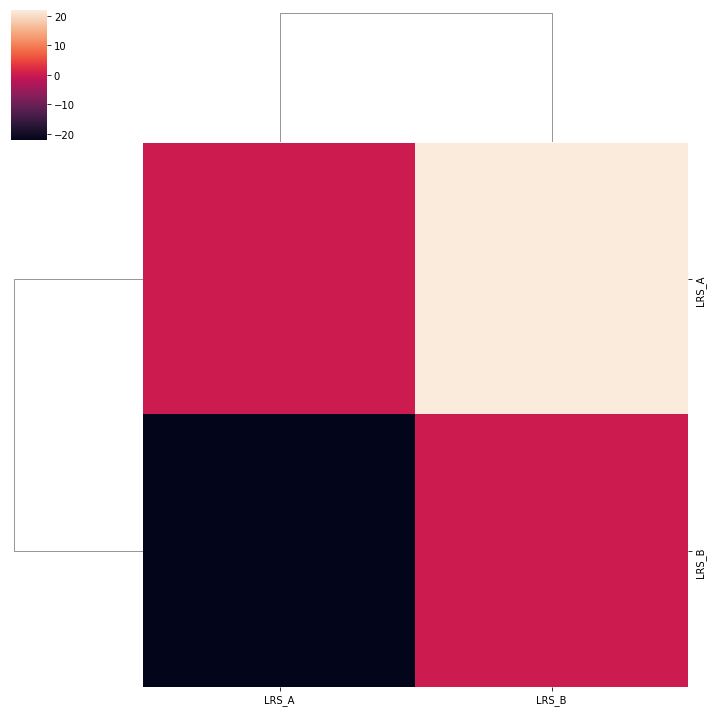

In [21]:
plot_overlap_heatmap(res_candida,{})

## Comparing the overlap between the two experiments 

### Comparing peptide overlap 

In [46]:
pep_over_lap:pd.DataFrame = exps.compute_peptide_overlap_matrix()
pep_over_lap

,LRS_A,LRS_B
LRS_A,2439.0,242.0
LRS_B,242.0,2660.0


#### Visualize all the results 

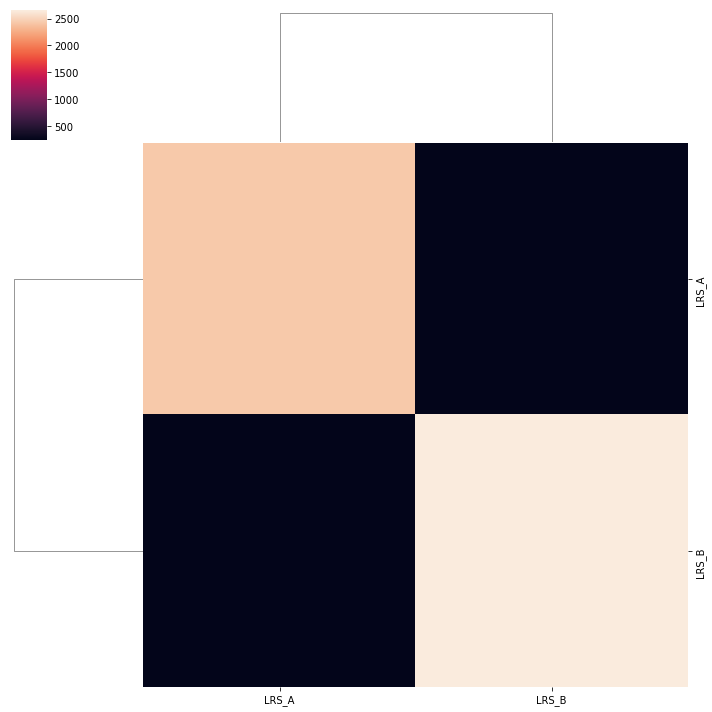

In [47]:
plot_overlap_heatmap(pep_over_lap,{})

### Comparing protein overlap 

In [48]:
pro_over_lap: pd.DataFrame = exps.compute_protein_overlap_matrix()
pro_over_lap

,LRS_A,LRS_B
LRS_A,730.0,294.0
LRS_B,294.0,724.0


#### Visualize all the results 

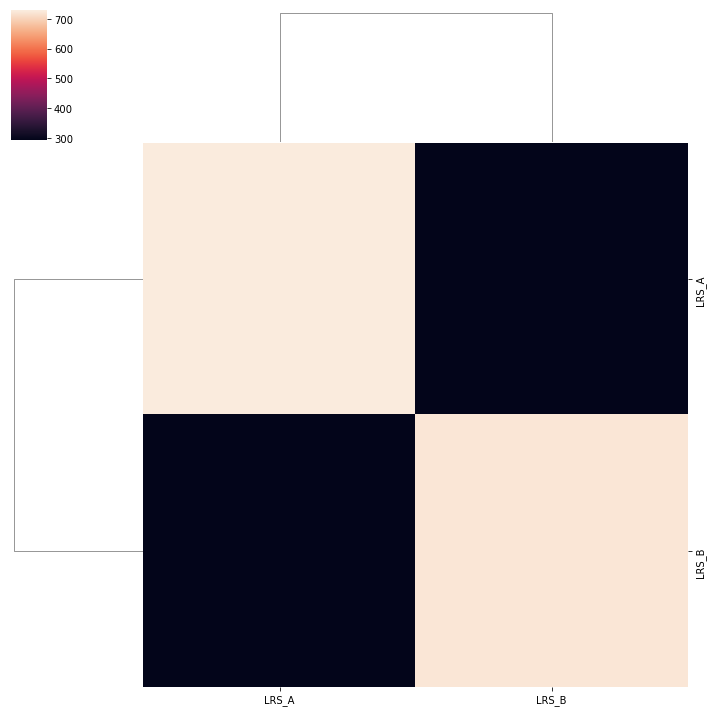

In [49]:
plot_overlap_heatmap(pro_over_lap,{})

## Drop all non-human proteins from the database 

In [32]:
unique_orgs=exps.get_unique_orgs()
for org in unique_orgs: 
    if org != 'HUMAN':
        exps.drop_peptides_belong_to_org(org_name=org)

### Correlation in the  gene expression of parent proteins between experiments

In [33]:
diff_exp: pd.DataFrame= exps.compute_correlation_in_experssion()

In [34]:
print(diff_exp)

,LRS_A,LRS_B
LRS_A,1.0,1.0
LRS_B,1.0,1.0


## Compute the average distance between the experiments using the average change in protein representation 

In [35]:
res: pd.DataFrame = exps.compute_average_distance_between_exps()
print(res)

         LRS_A    LRS_B
LRS_A      0.0  21501.0
LRS_B  21501.0      0.0


### Visualize the change in protein coverage accross experiments 

In [37]:
distance_tensor: np.ndarray = exps.compute_change_in_protein_representation()
    

In [65]:
def plot_change_in_presentation_between_experiment(
    change_in_presentation_array: np.ndarray, index_first: int, index_second:int, 
    plotting_kwargs: Dict[str,str] = {},
    title='Change in protein presentation',
    xlabel="Proteins", ylabel="magnitude of change in protein count") -> plt.Figure:
    """ 
    @brief: plot the change in protein presentation between two experiment 
    @param: change_in_presentation_array: a 3D tensor of shape number of experiments by 
    number of experiment by number of identified proteins. 
    @param: index_first: the index of the first experiment in the tensor. 
    @param: index_second: the index of the second experiment in the tensor. 
    @param: plotting_kwargs: a dict object containing parameters for the sns.scatterplot function.
    @param: title: The title of the figure
    @param: xlabel: The x-axis label of the figure 
    @param: ylabel: the y-axis label of the figure
    """
    # check the correct index 
    if len(change_in_presentation_array.shape)!=3:
        raise ValueError(f"The provided tensor must of be of rank 3, current tensor has rank: {len(change_in_presentation_array.shape)}")    
    
    if index_first > change_in_presentation_array.shape[0]:
        raise IndexError(f"The provided index for the first experiment is out of bound. Number of elements along the first axis is: {change_in_presentation_array.shape[0]}")
    
    if index_second > change_in_presentation_array.shape[1]:
        raise IndexError(f"The provided index for the second experiment is out of bound. Number of elements along the second axis is: {change_in_presentation_array.shape[1]}")
    # get the tensor 
    change_tensor=change_in_presentation_array[index_first,index_second,:].reshape(-1)
    # sort the tensor 
    change_tensor.sort()
    change_tensor=change_tensor[::-1]
    # plot the tensor elements 
    fig=plt.figure()
    ax=sns.scatterplot(x=np.arange(len(change_tensor)),y= change_tensor, **plotting_kwargs)
    plt.hlines(y=np.median(change_tensor), xmin=0,xmax=len(change_tensor),color='red')
    # add the axis labels 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add the title
    ax.set_title(title)
    # return the results 
    return fig

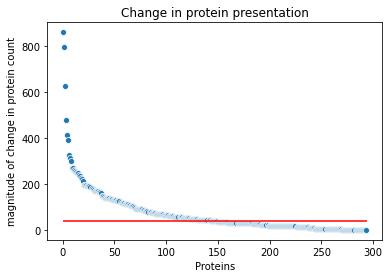

In [69]:
fig=plot_change_in_presentation_between_experiment(distance_tensor,0,1)